# Interventions and Causal Effects in Pyro

In [1]:
from statistics import mean
import torch
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt
%matplotlib inline

pyro.set_rng_seed(101)

To start, we implement the exact same survey model that we trained in the `bnlearn` tutorial.

In [2]:
A_alias = ['young','adult','old']
S_alias = ['M','F']
E_alias = ['high','uni']
O_alias = ['emp','self']
R_alias = ['small','big']
T_alias = ['car','train','other']

A_prob = torch.tensor([0.3,0.5,0.2])
S_prob = torch.tensor([0.6,0.4])
E_prob = torch.tensor([[[0.75,0.25], [0.72,0.28], [0.88,0.12]],
                     [[0.64,0.36], [0.7,0.3], [0.9,0.1]]])
O_prob = torch.tensor([[0.96,0.04], [0.92,0.08]])
R_prob = torch.tensor([[0.25,0.75], [0.2,0.8]])
T_prob = torch.tensor([[[0.48,0.42,0.1], [0.56,0.36,0.08]],
                     [[0.58,0.24,0.18], [0.7,0.21,0.09]]])

def model():
    A = pyro.sample("A", dist.Categorical(probs=A_prob))
    S = pyro.sample("S", dist.Categorical(probs=S_prob))
    E = pyro.sample("E", dist.Categorical(probs=E_prob[S][A]))
    O = pyro.sample("O", dist.Categorical(probs=O_prob[E]))
    R = pyro.sample("R", dist.Categorical(probs=R_prob[E]))
    T = pyro.sample("T", dist.Categorical(probs=T_prob[R][O]))
    return{'A': A,'S': S,'E': E,'O': O,'R': R,'T': T}

print(model())

{'A': tensor(1), 'S': tensor(1), 'E': tensor(0), 'O': tensor(0), 'R': tensor(1), 'T': tensor(2)}


We can condition on someone being self-employed (O = 1) and living in a big city.

In [3]:
conditioned_model = pyro.condition(model, data={'O':torch.tensor(1),'R':torch.tensor(1)})

From this we can predict the person's age.  Here, I use simple importance sampling for the inference algorithm.

Text(0.5, 1.0, 'P(A | O = self, R = big) - Importance Sampling')

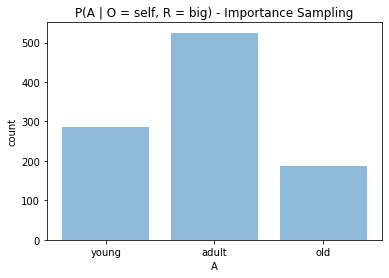

In [4]:
A_posterior = pyro.infer.Importance(conditioned_model, num_samples=5000).run()
A_marginal = EmpiricalMarginal(A_posterior,"A")
A_samples = [A_marginal().item() for _ in range(1000)]
A_unique, A_counts = np.unique(A_samples, return_counts=True)

plt.bar(A_unique, A_counts, align='center', alpha=0.5)
plt.xticks(A_unique, A_alias)
plt.ylabel('count')
plt.xlabel('A')
plt.title('P(A | O = self, R = big) - Importance Sampling')

## Interventions and causal effect estimation

So our model is working just as it did with `bnlearn`. Just as before, let's do the intervention on Residence (R) and see it's effect on Occupation (O).

First we view the distribution of occupation in large cities.

In [5]:
big_city_model = pyro.do(model, data={'R': torch.tensor(1)})


Text(0.5, 1.0, 'P(T | do(R = big)) - Importance Sampling')

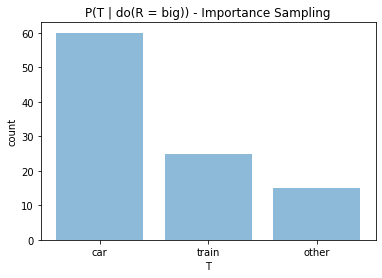

In [6]:
T_samples = [big_city_model()['T'] for _ in range(100)]
T_unique, T_counts = np.unique(T_samples, return_counts=True)
plt.bar(T_unique, T_counts, align='center', alpha=0.5)
plt.xticks(T_unique, T_alias)
plt.ylabel('count')
plt.xlabel('T')
plt.title('P(T | do(R = big)) - Importance Sampling')

Next, we calculate the causal effect of city size on car use.

In [7]:
small_city_model = pyro.do(model, data={'R': torch.tensor(0)})

In [8]:
t_samples_big = [
    1 if big_city_model()['T'] == 0.0 else 0
    for _ in range(50000)
]
t_samples_small = [
    1 if small_city_model()['T'] == 0.0 else 0
    for _ in range(50000)
]

causal_effect = mean(t_samples_big) - mean(t_samples_small)
causal_effect

0.1033